#Colab 1: Learn to use Apache Spark with Python (30 points)

In this lab you will learn how to use [Apache Spark](https://spark.apache.org) on a Colab enviroment.

### **Setup**

Let's setup Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 204.2MB 21kB/s 
     |████████████████████████████████| 204kB 49.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=5e5ad643c0a71cd40b95cd0d20507b52b05786f01dbb15cb948a4cea8e77f2e3
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 12 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

Now we authenticate a Google Drive client to download files. Please follow the instruction to enter the authoriztion code.


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Now download the file we will be processing in our Spark job.

In [3]:
id='11xoXxyX1rFB-EabHt1cqRkf5nULcs25t'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('game-clicks.csv.gz') 

id='1ji6ulH3Q56wGIdCSBgglUQn4-irJXVYX'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('ad-clicks.csv.gz')
print(type(downloaded)) 


<class 'pydrive.files.GoogleDriveFile'>


If you executed the cells above, you should be able to see the files under the "Files/content" folder on the left panel.

Import libraries.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Initialize the Spark context.


In [5]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **Load `game-clicks` and `ad-clicks` datasets**



Load the datasets:

In [6]:
gameclicks = spark.read.csv("game-clicks.csv.gz", header='true')
adclicks = spark.read.csv("ad-clicks.csv.gz", header='true')

Check the schemas:

In [7]:
gameclicks.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- clickId: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- userSessionId: string (nullable = true)
 |-- isHit: string (nullable = true)
 |-- teamId: string (nullable = true)
 |-- teamLevel: string (nullable = true)



In [8]:
adclicks.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- txId: string (nullable = true)
 |-- userSessionId: string (nullable = true)
 |-- teamId: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- adId: string (nullable = true)
 |-- adCategory: string (nullable = true)



Get a formatted sample with `show()`:

In [9]:
gameclicks.show(10)

+-------------------+-------+------+-------------+-----+------+---------+
|          timestamp|clickId|userId|userSessionId|isHit|teamId|teamLevel|
+-------------------+-------+------+-------------+-----+------+---------+
|2016-05-26 15:06:55|    105|  1038|         5916|    0|    25|        1|
|2016-05-26 15:07:09|    154|  1099|         5898|    0|    44|        1|
|2016-05-26 15:07:14|    229|   899|         5757|    0|    71|        1|
|2016-05-26 15:07:14|    322|  2197|         5854|    0|    99|        1|
|2016-05-26 15:07:20|     22|  1362|         5739|    0|    13|        1|
|2016-05-26 15:07:27|    107|  1071|         5939|    0|    27|        1|
|2016-05-26 15:07:30|    289|  2359|         5764|    0|    85|        1|
|2016-05-26 15:07:30|    301|  1243|         5900|    0|    86|        1|
|2016-05-26 15:07:47|    274|  1628|         5896|    0|    82|        1|
|2016-05-26 15:07:48|     66|   453|         5662|    0|    20|        1|
+-------------------+-------+------+--

Find the number of records:

In [10]:
print("In total there are {0} game clicks".format(gameclicks.count()))

print("In total there are {0} ad clicks".format(adclicks.count()))


In total there are 755806 game clicks
In total there are 16323 ad clicks


## **Question 1: How many users in each team?**
Keywords: `Dataframe API`, `SQL`, `group by`, `sort`

Use [DataFrame API](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) to group the users by `teamID` and count how many distinct users in each team. Sort the result in descending order.

In [11]:
#team_counts = # your code goes here (Q1a: 4 points)
team_counts = gameclicks.groupBy('teamId').agg(countDistinct('userId'))

team_counts.show()

+------+-------------+
|teamId|count(userId)|
+------+-------------+
|   125|            5|
|   124|            9|
|    51|           18|
|    54|           18|
|   155|            5|
|   154|            4|
|   132|            9|
|    11|           16|
|   138|            6|
|    69|           11|
|   112|            7|
|    64|           25|
|   113|            7|
|   133|           11|
|    59|           16|
|   162|            6|
|   146|            5|
|     8|           16|
|   160|            5|
|    22|           33|
+------+-------------+
only showing top 20 rows



# Now rewrite the above question using pure SQL:

In [12]:
gameclicks.registerTempTable("gameclicks")

#query = # your code goes here (Q1b: 2 points)
query = "Select teamId, count(distinct userId) as numUsers from gameclicks group by teamId"

team_counts = spark.sql(query)
team_counts.show()

# how many unique teams are there
#num_teams = spark.sql("select count(distinct teamId) from gameclicks")
#num_teams.show()

+------+--------+
|teamId|numUsers|
+------+--------+
|   125|       5|
|   124|       9|
|    51|      18|
|    54|      18|
|   155|       5|
|   154|       4|
|   132|       9|
|    11|      16|
|   138|       6|
|    69|      11|
|   112|       7|
|    64|      25|
|   113|       7|
|   133|      11|
|    59|      16|
|   162|       6|
|   146|       5|
|     8|      16|
|   160|       5|
|    22|      33|
+------+--------+
only showing top 20 rows



##The `team_counts` Dataframe is small enough to be moved to Pandas:

In [13]:
team_counts_pd = team_counts.toPandas()
team_counts_pd.head()

,teamId,numUsers
0,125,5
1,124,9
2,51,18
3,54,18
4,155,5


##Plot a histogram using the number of users by team:

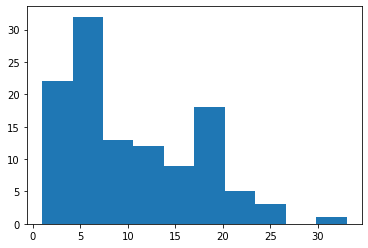

In [14]:
x = team_counts_pd['numUsers']
plt.hist(x)
plt.show()

----

## **Questions 2: Now use the `ad-clicks` dataset to find the number of ad clicks in each hour.**

Keywords: `group by`, `parse timestamp`, `plot`

In [15]:
timestamp_only = adclicks.selectExpr(["to_timestamp(timestamp) as timestamp"])

#click_count_by_hour = # your code goes here (Q2a: 4 points)
click_count_by_hour = timestamp_only.groupBy(hour('timestamp')).agg(count('timestamp')).orderBy(hour('timestamp'))

click_count_by_hour.show(100)

+---------------+----------------+
|hour(timestamp)|count(timestamp)|
+---------------+----------------+
|              0|             605|
|              1|             728|
|              2|             633|
|              3|             552|
|              4|             614|
|              5|             691|
|              6|             710|
|              7|             704|
|              8|             726|
|              9|             799|
|             10|             705|
|             11|             648|
|             12|             714|
|             13|             647|
|             14|             623|
|             15|             695|
|             16|             707|
|             17|             662|
|             18|             686|
|             19|             603|
|             20|             675|
|             21|             756|
|             22|             696|
|             23|             744|
+---------------+----------------+



# Use line plot to show the number of clicks by hour:

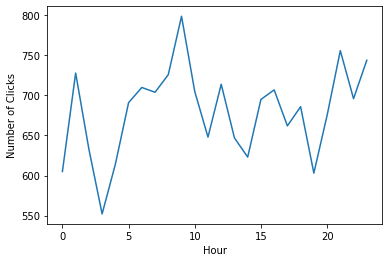

In [16]:
# your code goes here (Q2b: 4 points)
click_by_hour_pd = click_count_by_hour.toPandas()

num_clicks = click_by_hour_pd['count(timestamp)']
the_hour = click_by_hour_pd['hour(timestamp)']

plt.xlabel(xlabel='Hour')
plt.ylabel(ylabel='Number of Clicks')

plt.plot(the_hour,num_clicks)



## Question 3: Use `map` and `reduce` with RDD

Keywords: `RDD map reduce`

Now we want to find the number of clicks of each `adCategorory` using `map` and `reduce` with RDD. Since we only care the `adCategory`, let's select this column only.

In [17]:
categoryOnly = adclicks.select("adCategory")
categoryOnly.show(10)


+-----------+
| adCategory|
+-----------+
|electronics|
|     movies|
|  computers|
|    fashion|
|   clothing|
|      games|
|     movies|
|electronics|
|electronics|
|  computers|
+-----------+
only showing top 10 rows



Now use explicit Map/Reduce format with RDDs.

First we emit a pair in the format (`adCategory`, 1) by using a `map()` function:

In [43]:
type(categoryOnly)

# first convert it into a RDD object to use the map() 

all_categories = (adclicks.rdd).map(lambda x: (x['adCategory'],1))

# this map function returns a tuple of(categoryName,1) that is a single instance
all_categories.take(10)

[('electronics', 1),
 ('movies', 1),
 ('computers', 1),
 ('fashion', 1),
 ('clothing', 1),
 ('games', 1),
 ('movies', 1),
 ('electronics', 1),
 ('electronics', 1),
 ('computers', 1)]

Then, we sum counts by using a `reduce()` function, and then we sort by count:

In [71]:
category_counts_rdd = all_categories.reduceByKey(lambda x,y:x +y)


counts =category_counts_rdd.take(10)

# I don't know how to sort it as a rdd. I can sort it as a list afterwards
counts.sort(key=lambda x:x[1], reverse=True)
print(counts)

[('computers', 2638), ('games', 2601), ('clothing', 2340), ('sports', 2074), ('fashion', 1727), ('movies', 1692), ('hardware', 1588), ('electronics', 1097), ('automotive', 566)]


Now we want to convert the `category_counts_rdd` to a dataframe `category_counts` by mappying the corresponding columns.

In [72]:
category_counts = category_counts_rdd.toDF()

# I ordered them here
category_counts.orderBy('_2').show()

+-----------+----+
|         _1|  _2|
+-----------+----+
| automotive| 566|
|electronics|1097|
|   hardware|1588|
|     movies|1692|
|    fashion|1727|
|     sports|2074|
|   clothing|2340|
|      games|2601|
|  computers|2638|
+-----------+----+



Now use SparkSQL to verify the above result:

In [76]:

adclicks.registerTempTable("adclicks")

query = 'SELECT adCategory, count(*) as number_of_clicks FROM adclicks group by adCategory order by count(*)'
category_counts = spark.sql(query)
category_counts.show()


+-----------+----------------+
| adCategory|number_of_clicks|
+-----------+----------------+
| automotive|             566|
|electronics|            1097|
|   hardware|            1588|
|     movies|            1692|
|    fashion|            1727|
|     sports|            2074|
|   clothing|            2340|
|      games|            2601|
|  computers|            2638|
+-----------+----------------+



#Congratulations on the first Spark assignment!